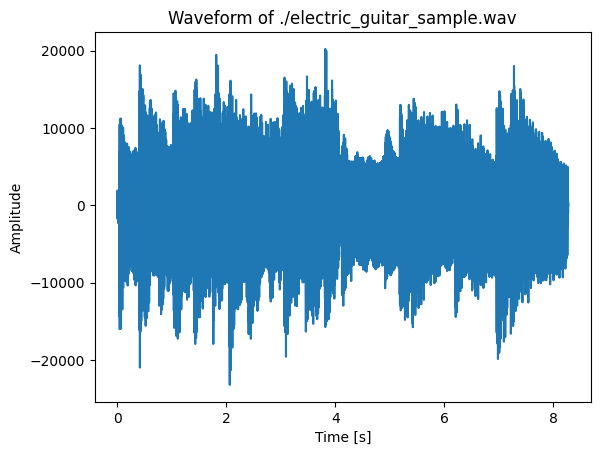

In [1]:
# open wave file and plot as input waveform

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import time as t

file_path = "./electric_guitar_sample.wav"

with wave.open(file_path, 'r') as wave_file:
    # get the number of frames
    n_frames = wave_file.getnframes()
    # read the frames
    frames = wave_file.readframes(n_frames)
    # convert frames to integers
    frames = np.frombuffer(frames, dtype=np.int16)

    # get the frame rate
    frame_rate = wave_file.getframerate()*2 # there are 2 samples per frame, so technically this is sample rate rather than frame rate
    # get the time values for the x axis
    time = np.linspace(0, len(frames) / frame_rate, num=len(frames))

    # plot the waveform
    plt.figure()
    plt.plot(time, frames, label='Waveform')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + file_path)
    plt.show()


In [54]:
#playback origianl waveform using pyaudio NOT SUPPORTED ON PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)

# play the audio
stream.write(frames.tobytes())


In [55]:
# save frames to .wav file
wavfile.write('outputs/original.wav', frame_rate, frames)

# Distortion Algorithm

In [56]:
def distort(waveform: np.ndarray, threshold: int, clip_factor: float) -> list:
    """Distort the waveform by clipping the values above the threshold and below the negative threshold and softening the clipped values."""
    # This function will be replaced by HLS code
    distorted_waveform = waveform

    # apply clipping
    distorted_waveform = np.where(distorted_waveform > threshold, (distorted_waveform - threshold) * clip_factor + threshold, distorted_waveform)
    distorted_waveform = np.where(distorted_waveform <  -threshold, (distorted_waveform - threshold) * clip_factor - threshold, distorted_waveform)
    # print(type(waveform))
    # print(type(distorted_waveform))
    distorted_waveform = distorted_waveform.astype(np.int16)
    return distorted_waveform
    
    
    

Time to distort:  0.028078794479370117


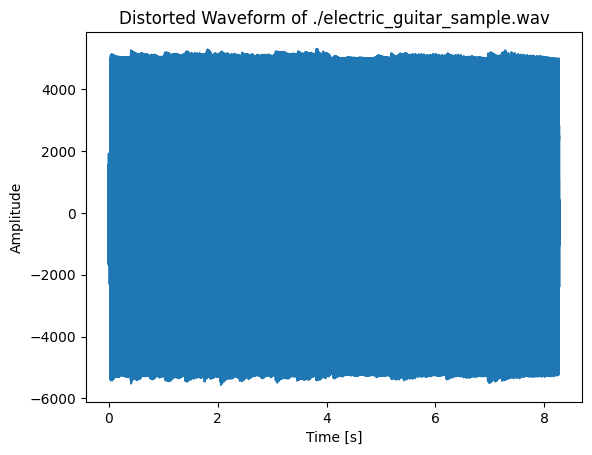

In [57]:


distorted_frames = frames # make a copy of the original waveform

threshold = 5000 # this is the amplitude that will start the audio clipping
clip_factor = 0.02 # this is the factor that will soften the clipped audio

start = t.time()
distorted_frames = distort(distorted_frames, threshold, clip_factor)
end = t.time()

print("Time to distort: ", end - start)

# plot the waveform
plt.figure()
plt.plot(time, distorted_frames, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Distorted Waveform of ' + file_path)
plt.show()

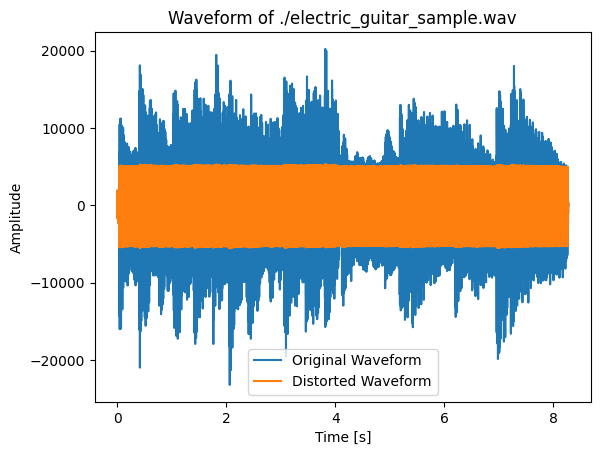

[ 0  0 42 ...  4  4  2]


In [58]:
#plot frames and distored frames together to show the difference
plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, distorted_frames, label='Distorted Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()
print(distorted_frames)

In [10]:
#playback waveform using pyaudio NOT SUPPORTED ON PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)

# play the audio
stream.write(distorted_frames.tobytes())


In [59]:
# save frames to .wav file
wavfile.write('outputs/distorted.wav', frame_rate, distorted_frames)

# Compression Algorithm

In [61]:
# Amplitude detection used in compression algorithm
# THIS USES A FIR LOW PASS FILTER

def detect_amplitude(waveform: np.array) -> list:
    """Returns a np.array of equal lenght corresponding to the amplitude of the waveform at that point."""
    # This function will be replaced by HLS code
    rectified_signal = np.abs(waveform)

    # now apply a low pass filter to the rectified signal to envelop detect
    filter_length = frame_rate // 200 # frame rate over lowest frequency
    filter = np.ones(filter_length) / filter_length # create a filter which will just average the signal over the filter length
    filter = filter * 3 # normalize to match amplitude of wave
    envelope = np.convolve(rectified_signal, filter, mode='same') # convolve filter with signal
    return envelope


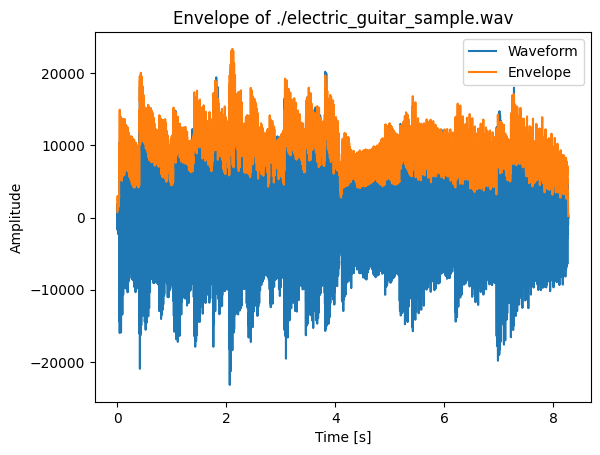

In [62]:
# plot the envelope of the waveform with the waveform
#on pynq board, userwarning will be generated but plot will still be generated after a long time
plt.figure()
plt.plot(time, frames, label='Waveform')
plt.plot(time, detect_amplitude(frames), label='Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Envelope of ' + file_path)
plt.legend()
plt.show()


In [63]:
# compression algorithm!

def compress(waveform: np.array, min_threshold: int, max_threshold: int, zero_threshold: int) -> list:
    """Compress the waveform by reducing the amplitude of the values above the threshold by the given ratio."""
    # This function will be replaced by HLS code
    envelope = detect_amplitude(waveform)
    compressed_waveform = list(waveform)
    # if sample is not loud enough, make louder, if too loud make quiter
    for i, sample in enumerate(compressed_waveform):
        if envelope[i] > max_threshold:
            compression_factor = envelope[i] / max_threshold
            compressed_waveform[i] = sample / compression_factor
        elif envelope[i] < min_threshold and envelope[i] > zero_threshold:
            compression_factor = min_threshold / envelope[i]
            compressed_waveform[i] = sample * compression_factor
    
    compressed_waveform = np.array(compressed_waveform, dtype="int16")
    return compressed_waveform

Time to compress:  0.37634825706481934


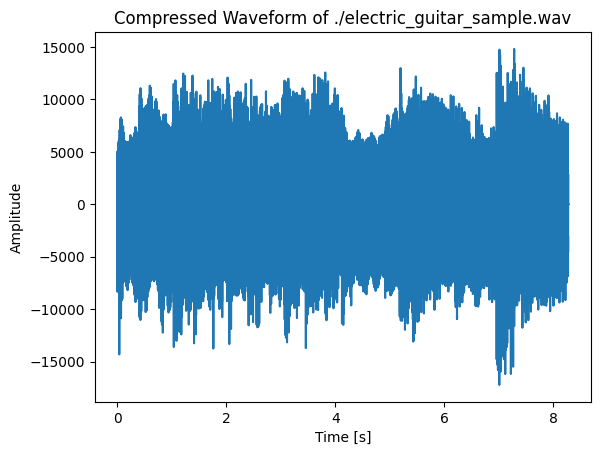

In [64]:
# calculate the whole waveform and plot
start = t.time()
compressed_frames = compress(frames, 7000, 9000, 1000)
end = t.time()
print("Time to compress: ", end - start)
plt.figure()
plt.plot(time, compressed_frames, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Compressed Waveform of ' + file_path)
plt.show()


C:\Users\kaden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


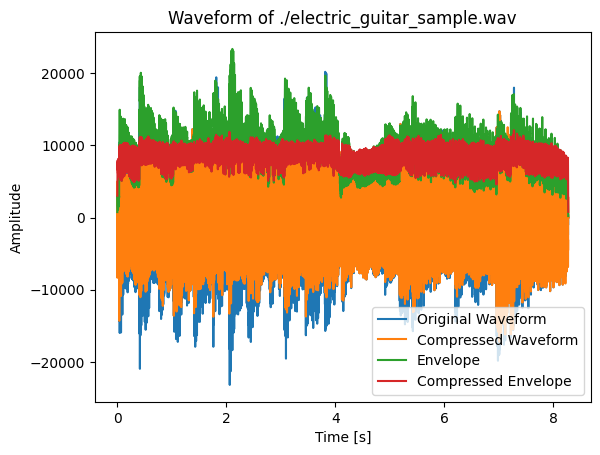

In [65]:
# plot the compressed waveform with the original to compare visually
#plot frames and distored frames together to show the difference
plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, compressed_frames, label='Compressed Waveform')
# asd respective envelopes
plt.plot(time, detect_amplitude(frames), label='Envelope')
plt.plot(time, detect_amplitude(compressed_frames), label='Compressed Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()

# note that envelope is more steady on compressed waveform, which is what is wanted!

In [66]:
# playback compressed waveform
#playback distorted waveform using pyaudio NOT SUPPPORTED BY PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)
# play the audio
stream.write(compressed_frames.tobytes())




In [67]:
# save frames to .wav file
wavfile.write('outputs/compressed.wav', frame_rate, compressed_frames)

# Delay Algorithm

In [26]:
# delay algorithm!!!
def delay(waveform: np.array, delay_samples: int, delay_gain: float) -> list:
    """Adds a delayed version of the waveform to itself with the given delay and gain."""
    # This function will be replaced by HLS code
    delayed_waveform = list(waveform)
    for i in range(delay_samples, len(waveform)):
        delayed_waveform[i] = delayed_waveform[i] + (delayed_waveform[i - delay_samples] * delay_gain)
    # cast as int16
    delayed_waveform = np.array(delayed_waveform, dtype="int16")
    return delayed_waveform

44100


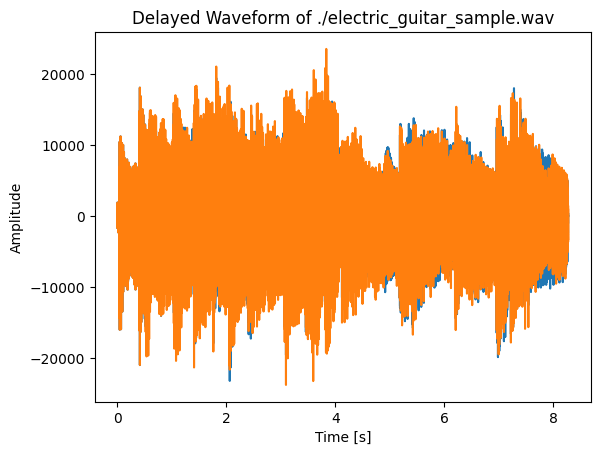

In [61]:
# plot the delayed waveform with the original to compare visually
delay_gain = 0.4 # this is the gain of the delayed signal, should be < 1
tempo = 140
frame_delay = frame_rate // (tempo//60)
print(frame_delay)

delayed_waveform = delay(frames, frame_delay, delay_gain)
plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, delayed_waveform, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Delayed Waveform of ' + file_path)
plt.show()


In [62]:
##playback waveform using pyaudio NOT SUPPORTED ON PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)

# play the audio
stream.write(delayed_waveform.tobytes())

In [63]:
# save delayed waveform to .wav file
wavfile.write('outputs/delayed.wav', frame_rate, delayed_waveform)

# Wah Effect

In [68]:
# wah effect
# basically a bandpass filter that will change center frequency based on an input signal

def wah(waveform: np.array, control_signal: np.array, min_freq: int, max_freq: int) -> list:
    """Applies a wah effect to the waveform based on the control signal."""
    # This function will be replaced by HLS code
    wahed_waveform = list(waveform)
    for i, sample in enumerate(waveform):
        print("on sample ", i)
        freq = min_freq + (max_freq - min_freq) * (control_signal[i] / max(control_signal)) # map the control signal to a frequency
        # create a bandpass filter
        bandpass = np.sin(2 * np.pi * freq * i / frame_rate)
        wahed_waveform[i] = sample * bandpass
    wahed_waveform = np.array(wahed_waveform, dtype="int16")
    return wahed_waveform


In [69]:
# wah the waveform and plot

# generate a sin wave osciallating with tempo normalized to 0-1
control_signal = np.sin(2 * np.pi * np.linspace(0, len(frames) / frame_rate, num=len(frames)) * (tempo / 60))
print(control_signal)
wahed_waveform = wah(frames, control_signal, 200, 2000)

plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, wahed_waveform, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Wah Waveform of ' + file_path)
plt.show()



[0.00000000e+00 1.66222060e-04 3.32444116e-04 ... 9.29040353e-01
 9.28978841e-01 9.28917304e-01]
on sample  0
on sample  1
on sample  2
on sample  3
on sample  4
on sample  5
on sample  6
on sample  7
on sample  8
on sample  9
on sample  10
on sample  11
on sample  12
on sample  13
on sample  14
on sample  15
on sample  16
on sample  17
on sample  18
on sample  19
on sample  20
on sample  21
on sample  22
on sample  23
on sample  24
on sample  25
on sample  26
on sample  27
on sample  28
on sample  29
on sample  30
on sample  31
on sample  32
on sample  33
on sample  34
on sample  35
on sample  36
on sample  37
on sample  38
on sample  39
on sample  40
on sample  41
on sample  42
on sample  43
on sample  44
on sample  45
on sample  46
on sample  47
on sample  48
on sample  49
on sample  50
on sample  51
on sample  52
on sample  53
on sample  54
on sample  55
on sample  56
on sample  57
on sample  58
on sample  59
on sample  60
on sample  61
on sample  62
on sample  63
on sample  64
on 

KeyboardInterrupt: 